In [11]:
# https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

In [2]:
import ee
import geemap

In [3]:
ee.Authenticate()

True

In [4]:
ee.Initialize()

In [36]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
# LST Land Surface Temperature
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [40]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
# LST Land Surface Temperature 
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [41]:
# Define the urban location of interest as a point at Nakameguro Tokyo.
u_lon = 139.698676
u_lat = 35.637453
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point at Karuizawa.
r_lon = 138.328
r_lat = 36.205
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [43]:
scale = 1000  # scale in meters

# Nakameguro Tokyo

# Print the elevation
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value:', lc_urban_point)

Ground elevation: 34 m
Average daytime LST: 24.42 °C
Land cover value: 13


In [44]:
# Karuizawa

# Print the elevation
elv_rural_point = elv.sample(r_poi, scale).first().get('elevation').getInfo()
print('Ground elevation:', elv_rural_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_rural_point = lst.mean().sample(r_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST:', round(lst_rural_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_rural_point = lc.first().sample(r_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value:', lc_rural_point)

Ground elevation: 983 m
Average daytime LST: 12.83 °C
Land cover value: 4


In [45]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  139.7015014098474,
  35.640658897442016,
  1483228800000,
  14377,
  145],
 ['2017_01_02', 139.7015014098474, 35.640658897442016, 1483315200000, None, 2],
 ['2017_01_03', 139.7015014098474, 35.640658897442016, 1483401600000, None, 2],
 ['2017_01_04', 139.7015014098474, 35.640658897442016, 1483488000000, None, 2]]

In [46]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [47]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,14.39
4,1483574400000,2017-01-05,12.55
9,1484006400000,2017-01-10,13.97
11,1484179200000,2017-01-12,13.03
14,1484438400000,2017-01-15,7.83


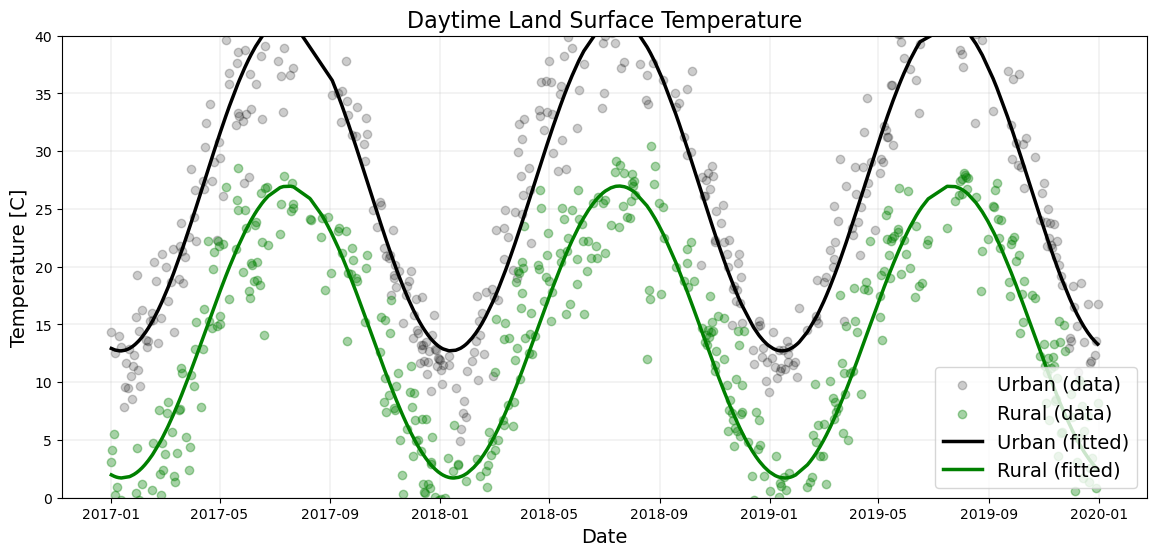

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [49]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)

In [50]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [51]:
from IPython.display import Image

# Create a URL to the styled image for a region.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/0c03a046e260a7c994cee154205fb079-00521a24c09a466ca1a8396d87570cf5:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [52]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))